<a href="https://colab.research.google.com/github/Luz-Dobbins/data-viz-wk17-codealongs-life-expectancy/blob/main/DataViz_Week17_Lect01_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔥 DataViz: Week 17, Lecture 01 - Challenge

## 🗺️ INSTRUCTIONS

>- Make a copy of this notebook
- Run the code in this notebook to create and evaluate the Linear Regression model at the bottom.
  - `Runtime` menu > `Run All`
- Scroll down to the regression model results and
- Answer the questions below the model and be prepared to discuss with the class.

Note: this notebook **does NOT follow best practices** (minimal EDA, removing outliers before train/test split, etc.). It is meant for discussion purposes.


# CODE


### Updating Scikit-Learn to V 1.1.3

In [ ]:
## UPDATING SKLEARN ON COLAB
!pip install scikit-learn==1.1.3

from IPython.display import clear_output
clear_output()

import sklearn as sk
vers = !python --version
print(f"Python Vers: {vers[0]}")
print(f"Scikit-learn Vers: {sk.__version__}")

Python Vers: Python 3.10.12
Scikit-learn Vers: 1.1.3


In [ ]:
## Import Standard Packages
import os, sys
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

In [ ]:
## Preprocessing Imports ([ ] TO DO: Consider making preprocess_imports module)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import (make_column_transformer, make_column_selector,
                             ColumnTransformer)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics

from sklearn.linear_model import LinearRegression

##import statsmodels correctly
import statsmodels.api as sm
from scipy import stats

## fixing random for lesson generation
SEED = 321
np.random.seed(SEED)

In [ ]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,as_frame=True):
  """Evaluates a scikit learn regression model using r-squared and RMSE.
  Returns the results a DataFrame if as_frame is True (Default).
  """
  ## Training Data
  y_pred_train = model.predict(X_train)
  r2_train = metrics.r2_score(y_train, y_pred_train)
  rmse_train = metrics.mean_squared_error(y_train, y_pred_train,
                                          squared=False)
  mae_train = metrics.mean_absolute_error(y_train, y_pred_train)


  ## Test Data
  y_pred_test = model.predict(X_test)
  r2_test = metrics.r2_score(y_test, y_pred_test)
  rmse_test = metrics.mean_squared_error(y_test, y_pred_test,
                                          squared=False)
  mae_test = metrics.mean_absolute_error(y_test, y_pred_test)

  ## if returning a dataframe:
  if as_frame:
      df_version =[['Split','R^2','MAE','RMSE']]
      df_version.append(['Train',r2_train, mae_train, rmse_train])
      df_version.append(['Test',r2_test, mae_test, rmse_test])
      df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
      df_results = df_results.round(2)


      # adapting hide_index for pd version
      if pd.__version__ < "1.4.0":
        display(df_results.style.hide_index().format(precision=2, thousands=','))
      else:
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))

  ## If not dataframe, just print results.
  else:
      print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
      print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")



def plot_residuals(model,X_test_df, y_test,figsize=(12,5)):
  """Plots a Q-Q Plot and residual plot for a regression model.
  """
  ## Make predictions and calculate residuals
  y_pred = model.predict(X_test_df)
  resid = y_test - y_pred

  fig, axes = plt.subplots(ncols=2,figsize=figsize)

  ## Normality
  sm.graphics.qqplot(resid, line='45',fit=True,ax=axes[0]);

  ## Homoscedascity
  ax = axes[1]
  ax.scatter(y_pred, resid, edgecolor='white',lw=0.5)
  ax.axhline(0,zorder=0)
  ax.set(ylabel='Residuals',xlabel='Predicted Value');
  fig.suptitle("Residual Plots", y=1.01)
  plt.tight_layout()


## Load Data

In [ ]:
## Load in data
FILE = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSEZQEzxja7Hmj5tr5nc52QqBvFQdCAGb52e1FRK1PDT2_TQrS6rY_TR9tjZjKaMbCy1m5217sVmI5q/pub?output=csv"
df = pd.read_csv(FILE)

# setting index & dropping
# df = df.set_index('id')
use_cols = ['bedrooms','bathrooms','sqft_living','yr_built','waterfront',
            'floors','price']
df = df[use_cols].copy()
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     21613 non-null  int64  
 1   bathrooms    21613 non-null  float64
 2   sqft_living  21613 non-null  int64  
 3   yr_built     21613 non-null  int64  
 4   waterfront   21613 non-null  int64  
 5   floors       21613 non-null  float64
 6   price        21613 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 1.2 MB


,bedrooms,bathrooms,sqft_living,yr_built,waterfront,floors,price
0,3,1.00,1180,1955,0,1.0,221900.0
1,3,2.25,2570,1951,0,2.0,538000.0
2,2,1.00,770,1933,0,1.0,180000.0
3,4,3.00,1960,1965,0,1.0,604000.0
4,3,2.00,1680,1987,0,1.0,510000.0


## EDA

> This notebook does NOT follow best practices (minimal EDA, removing outliers before train/test split, etc.)

In [ ]:
df.isna().sum()

bedrooms       0
bathrooms      0
sqft_living    0
yr_built       0
waterfront     0
floors         0
price          0
dtype: int64

In [ ]:
df.describe()

,bedrooms,bathrooms,sqft_living,yr_built,waterfront,floors,price
count,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,2.161300e+04
mean,3.370842,2.114757,2079.899736,1971.005136,0.007542,1.494309,5.401822e+05
std,0.930062,0.770163,918.440897,29.373411,0.086517,0.539989,3.673622e+05
min,0.000000,0.000000,290.000000,1900.000000,0.000000,1.000000,7.500000e+04
25%,3.000000,1.750000,1427.000000,1951.000000,0.000000,1.000000,3.219500e+05
50%,3.000000,2.250000,1910.000000,1975.000000,0.000000,1.500000,4.500000e+05
75%,4.000000,2.500000,2550.000000,1997.000000,0.000000,2.000000,6.450000e+05
max,33.000000,8.000000,13540.000000,2015.000000,1.000000,3.500000,7.700000e+06


### Checking the Target

<Axes: xlabel='price'>

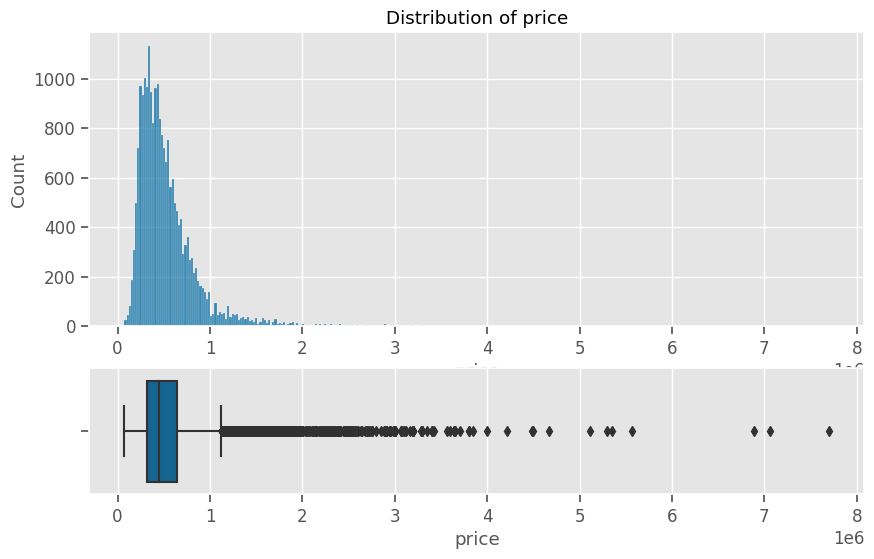

In [ ]:
## Plotting histogram and boxplot together
target = 'price'
grid_spec = {'height_ratios':[0.7,0.3]}

fig, axes = plt.subplots(nrows=2, figsize=(10,6),
                         gridspec_kw=grid_spec)
axes[0].set_title(f"Distribution of {target}")

sns.histplot(data=df, x=target, ax=axes[0])
sns.boxplot(data=df, x=target, ax=axes[1])

- This dataset is known to be a tricky regression without addressing assumptions of linear regression.
- Doing a M.V.P. removal of outliers, just from target.

#### Removing Outliers from Target

In [ ]:
## find outliers
idx_outliers = np.abs(stats.zscore(df[target]) )>3
idx_outliers.sum()

406

In [ ]:
# saving non-outliers
df = df[~idx_outliers].copy()
df

,bedrooms,bathrooms,sqft_living,yr_built,waterfront,floors,price
0,3,1.00,1180,1955,0,1.0,221900.0
1,3,2.25,2570,1951,0,2.0,538000.0
2,2,1.00,770,1933,0,1.0,180000.0
3,4,3.00,1960,1965,0,1.0,604000.0
4,3,2.00,1680,1987,0,1.0,510000.0
...,...,...,...,...,...,...,...
21608,3,2.50,1530,2009,0,3.0,360000.0
21609,4,2.50,2310,2014,0,2.0,400000.0
21610,2,0.75,1020,2009,0,2.0,402101.0
21611,3,2.50,1600,2004,0,2.0,400000.0


<Axes: xlabel='price'>

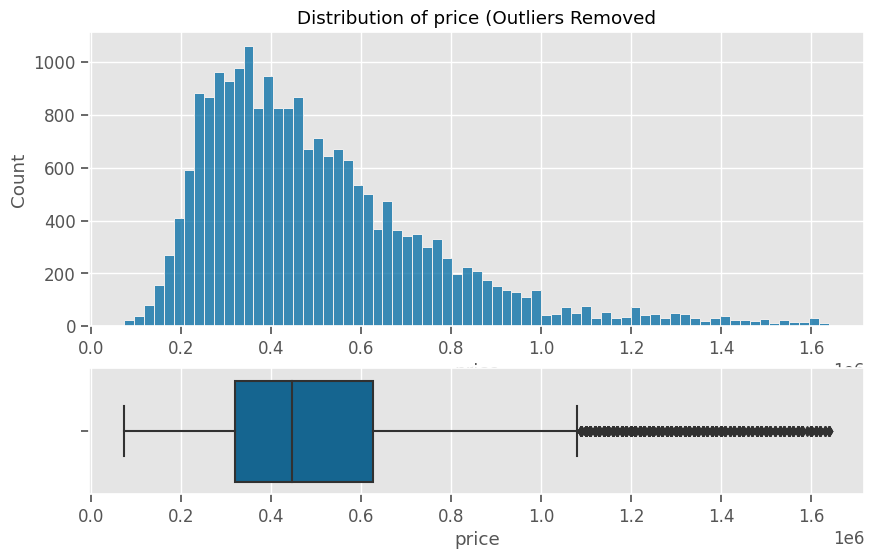

In [ ]:
# visualizing final target

fig, axes = plt.subplots(nrows=2, figsize=(10,6),
                         gridspec_kw=grid_spec)
axes[0].set_title(f"Distribution of {target} (Outliers Removed")

sns.histplot(data=df, x=target, ax=axes[0])
sns.boxplot(data=df, x=target, ax=axes[1])

### EDA: Features vs Target

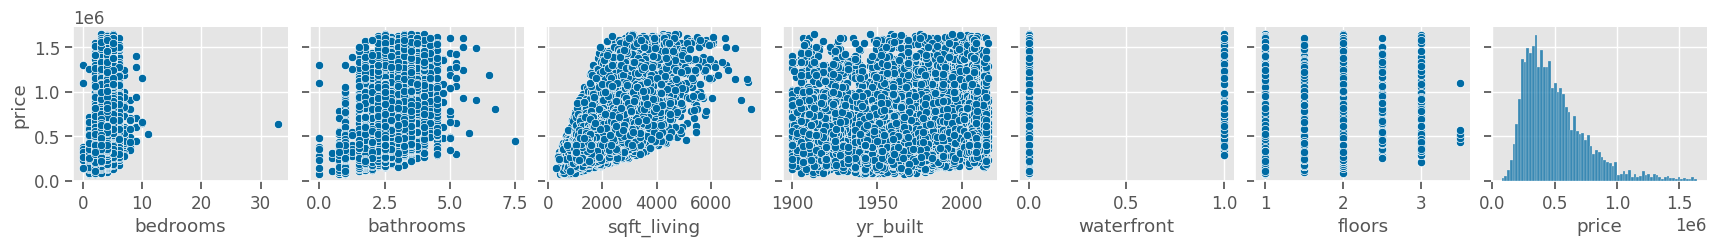

In [ ]:
fig_pairplot = sns.pairplot(df,y_vars='price');
fig_pairplot

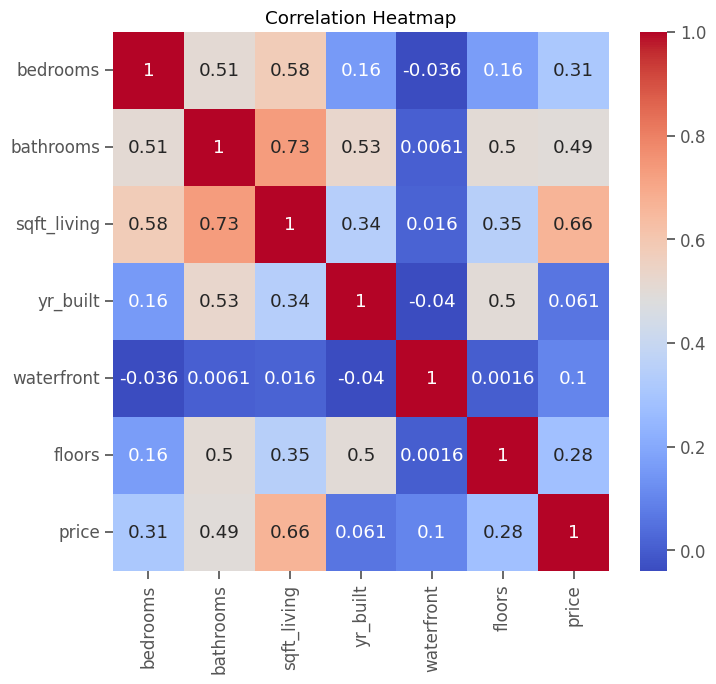

In [ ]:
fig_corr,ax = plt.subplots(figsize=(8,7))
sns.heatmap(df.corr(), annot=True, fmt= ".2g",cmap='coolwarm', ax=ax);
ax.set_title("Correlation Heatmap");

## Preprocessing

In [ ]:
## define X/y and train-test-split
target='price'
y = df[target].copy()
X = df.drop(columns=target).copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)


## make categorical preprocessing pipeline
cat_sel = make_column_selector(dtype_include='object')

cat_pipe = make_pipeline( SimpleImputer(strategy='constant',
                                        fill_value='MISSING'),
                         OneHotEncoder(drop='first',
                                       sparse=False)
                        )


## make numeric preprocessing pipeline
num_sel = make_column_selector(dtype_include='number')

num_pipe = make_pipeline( SimpleImputer(strategy='mean'))

>- Note: So far, all of the code should be familiar to you.
    -  With sklearn v1.1+, you should always add `verbose_feature_names_out=False` to column transformers *`ColumnTransformer`/ `make_column_transformer`)
        - (If you want to see what the verbose version looks like feel free to give it a try!)

In [ ]:
## make the preprocessing column transformer
preprocessor = make_column_transformer( (num_pipe, num_sel),
                                        (cat_pipe,cat_sel),
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f0b04319390>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f0b08865ea0>)],
                  verbose_feature_names_out=False)

In [ ]:

## Fit preprocessor and get feature names
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['bedrooms', 'bathrooms', 'sqft_living', 'yr_built', 'waterfront',
       'floors'], dtype=object)

In [ ]:
### PREP ALL X VARS AS DATAFRAMES
## Prepare X_train_df
X_train_df = pd.DataFrame( preprocessor.fit_transform(X_train),
                          columns = feature_names,
                         index = X_train.index)

## Prepare X_test_df
X_test_df = pd.DataFrame( preprocessor.transform(X_test),
                          columns = feature_names,
                         index=X_test.index)
X_train_df

,bedrooms,bathrooms,sqft_living,yr_built,waterfront,floors
8000,3.0,1.00,1120.0,1954.0,0.0,1.0
17746,4.0,1.75,1460.0,1967.0,0.0,1.0
10858,3.0,2.25,1820.0,1983.0,0.0,2.0
6804,3.0,2.50,1650.0,2000.0,0.0,2.0
20426,4.0,3.50,3500.0,2014.0,0.0,2.0
...,...,...,...,...,...,...
12173,4.0,2.00,1720.0,1971.0,0.0,1.0
6031,3.0,1.00,1490.0,1954.0,0.0,1.0
11217,3.0,1.75,2230.0,1949.0,0.0,1.0
4297,3.0,1.00,1250.0,1939.0,0.0,1.5


<a id="warmup"></a>

## Linear Regression

In [ ]:
## Features Used
X_train_df.head(3)

,bedrooms,bathrooms,sqft_living,yr_built,waterfront,floors
8000,3.0,1.00,1120.0,1954.0,0.0,1.0
17746,4.0,1.75,1460.0,1967.0,0.0,1.0
10858,3.0,2.25,1820.0,1983.0,0.0,2.0


In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)

LinearRegression()

In [ ]:
## evaluate model
evaluate_regression(lin_reg, X_train_df, y_train,
                    X_test_df, y_test)


Split,R^2,MAE,RMSE
Train,0.51,"135,627.66","181,581.37"
Test,0.53,"133,367.72","178,230.45"


# Challenge Question

Q1: Extract and Visualize the Coefficients.
  

In [ ]:
coeffs = lin_reg.coef_
coeffs

array([-3.83031744e+04,  4.81260203e+04,  2.14942024e+02, -2.59953536e+03,
        2.81242322e+05,  6.45140470e+04])

In [ ]:
features = lin_reg.feature_names_in_
features

coeffs = pd.Series(coeffs, index=features)
coeffs

bedrooms       -38303.174412
bathrooms       48126.020273
sqft_living       214.942024
yr_built        -2599.535356
waterfront     281242.321949
floors          64514.046964
dtype: float64

<Axes: >

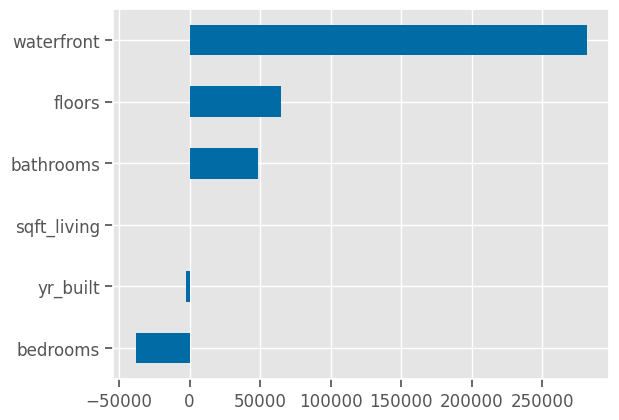

In [ ]:
coeffs.sort_values().plot(kind='barh')

Q2 : Plot the N most positive and N most negative features and interpret them.

> **Q3:** Interpret:

> What do these coefficients tell you about the data?